## This only exists for testing new data functions I may add, please make sure you are importing `datatools.jl` when working on the assignment 

In [4]:
using CSV, DataFrames, Statistics

In [5]:
const ROOT_PATH = @__DIR__
const DATA_PATH = "$ROOT_PATH/data"

"/home/justin/Documents/Spring2024/NumericalAnalysis/NA-FinalProject/data"

In [6]:
"""
get_datafiles(foldername::String)

takes in the name of a folder or path to subfolder in /data/
and returns an array of the paths to the different file names 


data_left_sideOf_center_dr = get_datafiles("Center/Left")

--> ["NA-FinalProject/data/Center/Left/Location-Justin-04-04", etc]
"""
function get_datafiles(foldername::String)
     filelist = readdir("$DATA_PATH/$foldername", join=true)
     return filelist
end


get_datafiles

In [7]:
"""
get_folder_dataframes(foldername::String)

takes in the name of a folder or the path to a subfolder in /data/
returns a vector of all the dataframes in that folder



sweetwater_dataframes = get_folder_dataframes("Sweetwater")

"""
function get_folder_dataframes(foldername::String)
     filelist = get_datafiles(foldername)

     dfs = []
     for path in filelist
          data = CSV.File(open(path)) |> DataFrame 
          push!(dfs, data)
     end
     return dfs
end

get_folder_dataframes

In [8]:
"""
filter_matching_rows(dfs::Vector{Any}, column_name::String; round_to::Int=6)

takes in a vector of dataframes and a column to filter them by. It looks through the dataframes
and keeps rows in which the values match. Can specify how close you want values to be by 
using round_to to adjust the precision. Returns a vector of the resulting dataframes


filtered_dfs = (dfs, "latitude"; round_to=5)
"""
function filter_matching_rows(dfs::Vector{Any}, column_name::String="latitude"; round_to::Int=5)
    # Ensure there is at least one data frame
    if isempty(dfs)
        error("The input vector must contain at least one data frame.")
    end
    
    # Ensure the column exists in all data frames
    for df in dfs
        if !(column_name in names(df))
            error("The specified column must exist in all data frames.")
        end
    end
    
    # Apply rounding and find the intersection of rounded values across all data frames
    rounded_values_sets = [Set(round.(df[!, column_name], digits=round_to)) for df in dfs]
    matching_values = reduce(intersect, rounded_values_sets)
    
    # Filter all data frames to only include rows with values (rounded) in the matching set
    filtered_dfs = [
        filter(row -> round(row[column_name], digits=round_to) in matching_values, df)
        for df in dfs
    ]
    
    return filtered_dfs
end


filter_matching_rows

In [9]:
"""
get_filtered_points(dfs::Vector{Any}, column_name::String; round_to::Int=6, only_unique::Bool=true)

Takes in vector of dataframes generated by get_folder_dataframes. User specifies a column_name 
by which to compare the dataframes. Values are rounded 6 by default, but can be changed. 
The dataframes are trimmed based on these matching rounded values, and only the columns 
latitude, longitude, and altitude are returned. These are all that are needed for displaying the
points 


filtered_points = get_filtered_points(folder_dataframes, "latitude"; round_to=3)

"""
function get_filtered_points(dfs::Vector{Any}, column_name::String="latitude"; round_to::Int=5, only_unique::Bool=true)
     filtered_dfs = filter_matching_rows(dfs, column_name; round_to=round_to)

     filtered_points = []

     for df in filtered_dfs
          map!(x->round(x, digits=round_to), df[!, column_name], df[!, column_name])
          new_df = select(df, ["latitude", "longitude", "altitude"])
          if only_unique
               unique!(new_df, column_name)
          end
          sort!(new_df, column_name)
          push!(filtered_points, new_df)
     end
     
     return filtered_points
end

get_filtered_points

In [10]:
"""
stack_df_vectors(dfs::Vector{Any})

Takes in a vector of dataframes and combines them into one dataframe. It adds in a column titled "sample" to indicate which
data sample a given row comes from. 
"""
function stack_df_vectors(dfs::Vector{Any})
     for i = 1:length(dfs)
          df = dfs[i]
          df.sample = fill("Sample $i", nrow(df))
     end

     a = dfs[1]
     for i = 2:length(dfs)
          append!(a, dfs[i])
     end
     
     return a
end

stack_df_vectors

In [11]:
"""
combine_df_vectors(dfs::Vector{Any})

This function takes in a vector of dataframes from the same road (similar samples).
It will compare the vectors and average them together. Unique sample latitudes will instead 
be appended into the new dataframe. The function assumes that you are passing in the returned value of 
get_filtered_points, but allows for you to set already_filtered=false if the data is unfiltered
"""
function combine_df_vectors(dfs::Vector{Any}; already_filtered::Bool=true, round_to::Int=5)

     if already_filtered
          dfs = dfs
     else
          dfs = get_filtered_points(dfs; round_to=round_to)
     end

     points = Dict()

     for df in dfs
          for i = 1:length(df[!, :1])
               if df.latitude[i] in keys(points)
                    push!((points[df.latitude[i]]).alt, df.altitude[i])
               else
                    points[df.latitude[i]] = (alt=[df.altitude[i]], long=df.longitude[i])
               end
          end
     end 

     lats = [k for k in keys(points)]
     longs = [v.long for v in values(points)]
     alts = [mean(v.alt) for v in values(points)]

     d = DataFrame(latitude=lats, longitude=longs, altitude=alts)

     sort!(d, "latitude")

     return d
          
end

combine_df_vectors

In [55]:
"""
    get_spaced_nodes(x, y, n=10; rev=true)

Takens in x and y values. returns 'n' number of spaced out points from the data.
By default this will return evenly spaced points, but setting fluctuation=SOME_INT will 
cause each index to fluctuate by ± the inputted value
"""
function get_spaced_nodes(x, y, n=10; fluctuation::Int=0)
     len = length(x)
     indices = round.(Int, LinRange(1, len, n))


     for i = 2:length(indices)-1
        indices[i] += rand((-1 * fluctuation):fluctuation)
     end
    
     @show indices

     if !issorted(x)
          sort!(x)
     end
           
     xs = x[indices]
     ys = y[indices]

     return xs, ys
 end

get_spaced_nodes

Everything below this line is in progress

---

In [20]:
dfs = get_folder_dataframes("Sweetwater");

In [21]:
df = dfs[1]

Row,time,seconds_elapsed,bearingAccuracy,speedAccuracy,verticalAccuracy,horizontalAccuracy,speed,bearing,altitude,longitude,latitude
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1712266854188000000,0.755,45.0,1.5,2.27256,72.9,0.0,0.0,7.94464,-82.3486,29.6437
2,1712266855367640000,1.93464,49.5444,0.778974,2.30127,7.681,0.724839,254.195,7.85234,-82.3487,29.6447
3,1712266856366407200,2.93341,69.841,1.44903,2.3401,6.398,0.778043,178.834,7.70673,-82.3487,29.6447
4,1712266857366600000,3.9336,73.7154,1.35204,2.33277,5.928,0.651252,179.991,7.6329,-82.3487,29.6447
5,1712266858367190800,4.93419,11.7684,0.700928,2.25,5.535,1.57199,175.987,7.59701,-82.3487,29.6447
6,1712266859366409700,5.93341,52.3302,1.18339,2.3297,5.273,1.34164,174.645,7.59804,-82.3487,29.6447
7,1712266860366214400,6.93321,45.0,1.5,2.78654,4.968,1.33165,174.799,7.98812,-82.3487,29.6447
8,1712266860698761000,7.26576,45.0,1.5,2.78654,4.385,1.32086,174.931,7.98812,-82.3487,29.6447
9,1712266861240709600,7.80771,45.0,0.319716,2.78654,4.44,1.05675,195.324,7.98812,-82.3487,29.6447


In [50]:
x = df.latitude;
y = df.altitude;

xn, yn = get_spaced_nodes(x, y)

indices = [1, 89, 176, 264, 352, 439, 527, 615, 702, 790]


([29.6416631, 29.6419735, 29.6423064, 29.6426106, 29.6429607, 29.6433151, 29.6437202, 29.6440727, 29.6443468, 29.644749], [7.944635942920804, 6.200000286102295, 5.400000095367432, 6.300000190734863, 6.400000095367432, 6.400000095367432, 2.700000047683716, 2.4000000953674316, -1.6999999284744263, -2.1999998092651367])

In [51]:
using Plots

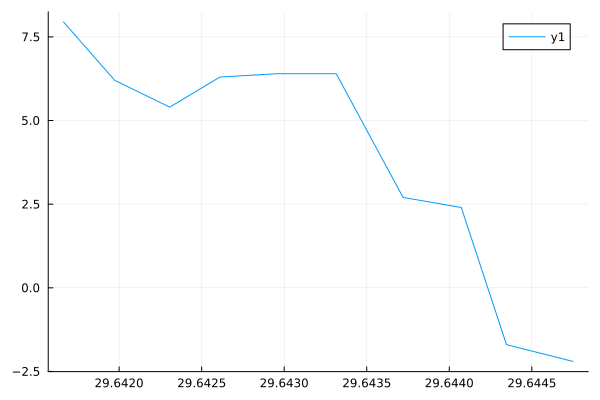

In [52]:
plot(xn, yn)


In [53]:
xn2, yn2 = get_spaced_nodes(x, y; fluctuation=5)

indices = [1, 94, 172, 260, 353, 435, 522, 620, 703, 790]


([29.6416631, 29.6419938, 29.6422964, 29.6425951, 29.642965, 29.6433029, 29.6436952, 29.6440947, 29.6443475, 29.644749], [7.944635942920804, 6.200000286102295, 5.400000095367432, 6.300000190734863, 6.400000095367432, 6.400000095367432, 2.700000047683716, 2.4000000953674316, -2.0999999046325684, -2.1999998092651367])

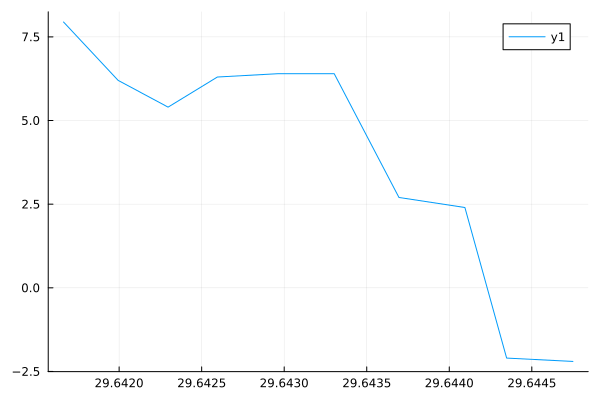

In [54]:
plot(xn2, yn2)